
# Predicting Hospital Readmission with Discharge Summaries

## Problem

Prediction of hospital readmission at admission time, within 24 hours, lacks information that would be included in discharge summaries

## Solution

Build machine learning models improve hospital resource utilization and reduce cost of unplanned readmission solely on discharge summaries. 

In [1]:
import os, sys, math, csv, datetime, time, pickle, json
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Load and analyse the ADMSSION dataset

In [2]:
admissions = pd.read_csv('ADMISSIONS.csv.gz', compression='gzip')

In [3]:
admissions.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

# Check for the NaN values on each column

In [4]:
for col in admissions.columns:
  print(col)
  print(admissions[col].isna().value_counts())
  print('-------------------------------------------------')

ROW_ID
False    58976
Name: ROW_ID, dtype: int64
-------------------------------------------------
SUBJECT_ID
False    58976
Name: SUBJECT_ID, dtype: int64
-------------------------------------------------
HADM_ID
False    58976
Name: HADM_ID, dtype: int64
-------------------------------------------------
ADMITTIME
False    58976
Name: ADMITTIME, dtype: int64
-------------------------------------------------
DISCHTIME
False    58976
Name: DISCHTIME, dtype: int64
-------------------------------------------------
DEATHTIME
True     53122
False     5854
Name: DEATHTIME, dtype: int64
-------------------------------------------------
ADMISSION_TYPE
False    58976
Name: ADMISSION_TYPE, dtype: int64
-------------------------------------------------
ADMISSION_LOCATION
False    58976
Name: ADMISSION_LOCATION, dtype: int64
-------------------------------------------------
DISCHARGE_LOCATION
False    58976
Name: DISCHARGE_LOCATION, dtype: int64
-------------------------------------------------
IN

In [5]:
admissions.shape

(58976, 19)

In [6]:
admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [7]:
admissions.SUBJECT_ID.unique().shape

(46520,)

In [8]:
len(set(map(lambda x: tuple(x), admissions[['SUBJECT_ID', 'HADM_ID']].values.tolist())))

58976

In [9]:
admissions[['HADM_ID', 'SUBJECT_ID']].duplicated().value_counts()

False    58976
dtype: int64


## Get the next admission date if it exists

We can get this with the shift() function, but we need to verify the dates are in order.


In [10]:
# get the NEXTADMITTIME for each patient
admissions.loc[:, 'NEXT_ADMITTIME'] = admissions.groupby('SUBJECT_ID')['ADMITTIME'].shift(-1)

In [11]:
admissions.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,NaN
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,2157-10-18 19:34:00
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,NaN
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,NaN
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,NaN


In [12]:
# sort by subject_ID and check for duplicates
admissions[admissions.duplicated('SUBJECT_ID', keep=False)].sort_values(['SUBJECT_ID', 'ADMITTIME'])

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME
224,14,17,194023,2134-12-27 07:15:00,2134-12-31 16:05:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,PATIENT FORAMEN OVALE\ PATENT FORAMEN OVALE MI...,0,1,2135-05-09 14:11:00
225,15,17,161087,2135-05-09 14:11:00,2135-05-13 14:40:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,ENGL,CATHOLIC,MARRIED,WHITE,2135-05-09 11:27:00,2135-05-09 13:45:00,PERICARDIAL EFFUSION,0,1,NaN
229,19,21,109451,2134-09-11 12:17:00,2134-09-24 16:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,NaN,JEWISH,MARRIED,WHITE,2134-09-11 09:22:00,2134-09-11 22:30:00,CONGESTIVE HEART FAILURE,0,1,2135-01-30 20:50:00
230,20,21,111970,2135-01-30 20:50:00,2135-02-08 02:08:00,2135-02-08 02:08:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,JEWISH,MARRIED,WHITE,2135-01-30 18:46:00,2135-01-30 22:05:00,SEPSIS,1,1,NaN
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,2157-10-18 19:34:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56415,58952,99923,164914,2201-02-23 20:42:00,2201-03-03 16:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,CATHOLIC,MARRIED,WHITE,2201-02-23 15:54:00,2201-02-23 21:58:00,HYPONATREMIA,0,1,2201-05-15 13:12:00
56416,58953,99923,192053,2201-05-15 13:12:00,2201-05-25 14:51:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Private,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,END STAGE LIVER DISEASE,0,1,NaN
56431,58968,99982,151454,2156-11-28 11:56:00,2156-12-08 13:45:00,NaN,EMERGENCY,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,TVR,0,1,2157-01-05 17:27:00
56432,58969,99982,112748,2157-01-05 17:27:00,2157-01-12 13:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2157-01-05 14:03:00,2157-01-05 18:50:00,SHORTNESS OF BREATH,0,1,2157-02-16 17:31:00


pd.to_datetime converts the date time string to date-time datatype

In [13]:
admissions['NEXT_ADMITTIME'] = pd.to_datetime(admissions['NEXT_ADMITTIME'])

In [14]:
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])

In [15]:
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])

In [16]:
# get the total number of days on hospital
admissions.loc[:, 'DAYS_IN_HOSPITAL'] = (admissions['DISCHTIME'] - admissions['ADMITTIME']).dt.days

In [17]:
# sort by subject_ID and admission date
adm = admissions.sort_values(['SUBJECT_ID', 'ADMITTIME'])

In [18]:
# get the days within next admit
adm['DAYS_WITHIN_NEXT_ADMIT'] = (adm['NEXT_ADMITTIME'] - adm['ADMITTIME']).dt.days

In [19]:
adm.DAYS_IN_HOSPITAL.isna().value_counts()

False    58976
Name: DAYS_IN_HOSPITAL, dtype: int64

In [20]:
# filling the negative values with 
adm.loc[adm['DAYS_WITHIN_NEXT_ADMIT'] < 0, 'DAYS_WITHIN_NEXT_ADMIT'] = pd.NaT

In [21]:
adm['DAYS_WITHIN_NEXT_ADMIT'].isna().value_counts()

True     46622
False    12354
Name: DAYS_WITHIN_NEXT_ADMIT, dtype: int64

In [22]:
# gine the counts of the patient admits within 30 days.
(adm.DAYS_WITHIN_NEXT_ADMIT <= 30).value_counts()

False    56449
True      2527
Name: DAYS_WITHIN_NEXT_ADMIT, dtype: int64

In [23]:
adm[['ADMITTIME', 'SUBJECT_ID', 'HADM_ID', 'DAYS_WITHIN_NEXT_ADMIT']]

,ADMITTIME,SUBJECT_ID,HADM_ID,DAYS_WITHIN_NEXT_ADMIT
211,2138-07-17 19:04:00,2,163353,NaN
212,2101-10-20 19:08:00,3,145834,NaN
213,2191-03-16 00:28:00,4,185777,NaN
214,2103-02-02 04:31:00,5,178980,NaN
215,2175-05-30 07:15:00,6,107064,NaN
...,...,...,...,...
56435,2181-01-27 02:47:00,99985,176670,NaN
56436,2184-12-24 08:30:00,99991,151118,NaN
56437,2144-07-25 18:03:00,99992,197084,NaN
56565,2147-02-08 08:00:00,99995,137810,NaN


In [24]:
adm.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME,DAYS_IN_HOSPITAL,DAYS_WITHIN_NEXT_ADMIT
211,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,3,NaN
212,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,NaT,10,NaN
213,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,...,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,NaT,7,NaN
214,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,2,NaN
215,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,NaT,16,NaN


In [25]:
adm['HOSPITAL_EXPIRE_FLAG'].value_counts()

0    53122
1     5854
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

In [26]:
adm.shape, admissions.shape

((58976, 22), (58976, 21))

In [27]:
cols = [
        'HOSPITAL_EXPIRE_FLAG',
        'HAS_CHARTEVENTS_DATA',
        'DAYS_IN_HOSPITAL',
        'DAYS_WITHIN_NEXT_ADMIT'
]

In [28]:
for col in cols:
  print(col)
  print(adm[col].unique())
  print('--------------------------------------------')

HOSPITAL_EXPIRE_FLAG
[0 1]
--------------------------------------------
HAS_CHARTEVENTS_DATA
[1 0]
--------------------------------------------
DAYS_IN_HOSPITAL
[  3  10   7   2  16   4   8  25  12   6   5  13   1  19   9  27  32  29
   0  15  14  18  58  17  80  91  22  28  33  24  20  11  31  75  70 107
  26  89  35  -1  76  23  61  21  49  30  54  47  59  85  60  56  81  46
  71  38 117  74  36  72  62  53  44  63  52  45  55  51  34  41  65  66
  97  87  37 145  64  50  42 108  39  43 113  84  48  69  40  86 137  95
  90  96 106 128  83 135 126 150  79 164  78  57 112 129  68  88 119  67
  82  99  73 101  94 123 100  93 173 155 191  77 151 138 140 131 125 202
 181 134 111 124 102 133 105  98 153 114 148 294 127 142 104  92 109 171
 118 120 132 144 167 166 115 116 103 110 163 161 122 121 141 169 136 206]
--------------------------------------------
DAYS_WITHIN_NEXT_ADMIT
[nan 133.0 141.0 ... 3045.0 721.0 1627.0]
--------------------------------------------


In [29]:
adm[adm.DAYS_WITHIN_NEXT_ADMIT.isna()].sort_values(['SUBJECT_ID', 'HADM_ID'])

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME,DAYS_IN_HOSPITAL,DAYS_WITHIN_NEXT_ADMIT
211,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,3,NaN
212,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,NaT,10,NaN
213,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,...,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,NaT,7,NaN
214,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,2,NaN
215,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,NaT,16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56435,58972,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,...,MARRIED,WHITE,2181-01-26 23:35:00,2181-01-27 04:18:00,FEVER,0,1,NaT,16,NaN
56436,58973,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,MARRIED,WHITE,NaN,NaN,DIVERTICULITIS/SDA,0,1,NaT,12,NaN
56437,58974,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,...,WIDOWED,WHITE,2144-07-25 13:40:00,2144-07-25 18:50:00,RETROPERITONEAL HEMORRHAGE,0,1,NaT,2,NaN
56565,58975,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,...,MARRIED,WHITE,NaN,NaN,ABDOMINAL AORTIC ANEURYSM/SDA,0,1,NaT,3,NaN


In [30]:
# get the max days between admits
adm['DAYS_WITHIN_NEXT_ADMIT'].max(), adm['DAYS_WITHIN_NEXT_ADMIT'].max() // 365

(4121.0, 11.0)

In [31]:
# fill the DAYS_WITHIN_NEXT_ADMIT NaN values with the 2 times the MAXIMUM vlaue in the same column - this means that the NaN means the patient takes around 22 years to get admit again which is of less importance
adm.loc[adm.DAYS_WITHIN_NEXT_ADMIT.isna(), 'DAYS_WITHIN_NEXT_ADMIT'] = 2*adm['DAYS_WITHIN_NEXT_ADMIT'].max()

In [32]:
for col in cols:
  print(col)
  print(adm[col].unique())
  adm[col] = adm[col].astype(float)
  print('--------------------------------------------')

HOSPITAL_EXPIRE_FLAG
[0 1]
--------------------------------------------
HAS_CHARTEVENTS_DATA
[1 0]
--------------------------------------------
DAYS_IN_HOSPITAL
[  3  10   7   2  16   4   8  25  12   6   5  13   1  19   9  27  32  29
   0  15  14  18  58  17  80  91  22  28  33  24  20  11  31  75  70 107
  26  89  35  -1  76  23  61  21  49  30  54  47  59  85  60  56  81  46
  71  38 117  74  36  72  62  53  44  63  52  45  55  51  34  41  65  66
  97  87  37 145  64  50  42 108  39  43 113  84  48  69  40  86 137  95
  90  96 106 128  83 135 126 150  79 164  78  57 112 129  68  88 119  67
  82  99  73 101  94 123 100  93 173 155 191  77 151 138 140 131 125 202
 181 134 111 124 102 133 105  98 153 114 148 294 127 142 104  92 109 171
 118 120 132 144 167 166 115 116 103 110 163 161 122 121 141 169 136 206]
--------------------------------------------
DAYS_WITHIN_NEXT_ADMIT
[8242  133  141 ... 3045  721 1627]
--------------------------------------------


In [33]:
adm.dtypes

ROW_ID                             int64
SUBJECT_ID                         int64
HADM_ID                            int64
ADMITTIME                 datetime64[ns]
DISCHTIME                 datetime64[ns]
DEATHTIME                         object
ADMISSION_TYPE                    object
ADMISSION_LOCATION                object
DISCHARGE_LOCATION                object
INSURANCE                         object
LANGUAGE                          object
RELIGION                          object
MARITAL_STATUS                    object
ETHNICITY                         object
EDREGTIME                         object
EDOUTTIME                         object
DIAGNOSIS                         object
HOSPITAL_EXPIRE_FLAG             float64
HAS_CHARTEVENTS_DATA             float64
NEXT_ADMITTIME            datetime64[ns]
DAYS_IN_HOSPITAL                 float64
DAYS_WITHIN_NEXT_ADMIT           float64
dtype: object

convert the time of the EMERGENCY IN AND OUT TIME to datetime datatype

In [34]:
adm['EDOUTTIME'] = pd.to_datetime(adm['EDOUTTIME'])

In [35]:
adm['EDREGTIME'] = pd.to_datetime(adm['EDREGTIME'])

In [36]:
(adm['EDOUTTIME'] - adm['EDREGTIME']).dt.total_seconds() / 86400

211           NaN
212      0.093750
213      0.500000
214           NaN
215           NaN
           ...   
56435    0.196528
56436         NaN
56437    0.215278
56565         NaN
56566         NaN
Length: 58976, dtype: float64

In [37]:
# get the TIME_IN_EMERGENCY_WARD IN DAYS, since all the columns are in date unit
adm['TIME_IN_EMERGENCY_WARD'] = (adm['EDOUTTIME'] - adm['EDREGTIME']).dt.total_seconds() / 86400

fill NaN values and negative values with 0 - means the patient stayed 0 days in the EMERGENCY WARD, means the patient did not stayed in emergency ward

In [38]:
adm.loc[adm['TIME_IN_EMERGENCY_WARD'] < 0, 'TIME_IN_EMERGENCY_WARD'] = 0

In [39]:
adm.loc[adm['TIME_IN_EMERGENCY_WARD'].isna(), 'TIME_IN_EMERGENCY_WARD'] = 0

<AxesSubplot:xlabel='TIME_IN_EMERGENCY_WARD'>

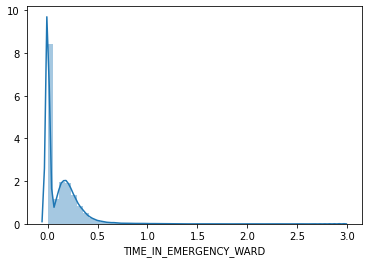

In [40]:
sns.distplot(adm['TIME_IN_EMERGENCY_WARD'])

In [41]:
# convert date string to pd.datetime
adm['DEATHTIME'] = pd.to_datetime(adm['DEATHTIME'])

In [42]:
(adm['DEATHTIME'] - adm['DISCHTIME']).value_counts()

0 days 00:00:00       5789
1 days 00:00:00         29
-1 days +00:00:00       13
2 days 00:00:00          3
-7 days +00:00:00        2
-30 days +00:00:00       1
33 days 00:00:00         1
20 days 00:00:00         1
-1 days +06:53:00        1
-31 days +00:00:00       1
54 days 00:00:00         1
-4 days +00:00:00        1
65 days 00:00:00         1
-1 days +04:35:00        1
3 days 00:00:00          1
-10 days +00:00:00       1
-1 days +12:23:00        1
-3 days +00:00:00        1
-1 days +08:10:00        1
-9 days +00:00:00        1
-1 days +13:30:00        1
12 days 00:00:00         1
-1 days +12:00:00        1
dtype: int64

# Obtain the difference between the death time and discharge time

In [43]:
# get the difference between the death time and discharge time
adm['DIFF_TIME_DEATH_DISCH'] = (adm['DISCHTIME'] - adm['DEATHTIME']).dt.days

In [44]:
adm['DIFF_TIME_DEATH_DISCH'].isna().value_counts()

True     53122
False     5854
Name: DIFF_TIME_DEATH_DISCH, dtype: int64

In [45]:
adm['DIFF_TIME_DEATH_DISCH'].value_counts()

 0.0     5795
-1.0       29
 1.0       13
-2.0        3
 7.0        2
-54.0       1
 4.0        1
-65.0       1
 9.0        1
 30.0       1
-20.0       1
 31.0       1
-3.0        1
 10.0       1
 3.0        1
-12.0       1
-33.0       1
Name: DIFF_TIME_DEATH_DISCH, dtype: int64

## Plot correlation value of the columns

In [46]:
adm.corr()

,ROW_ID,SUBJECT_ID,HADM_ID,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,DAYS_IN_HOSPITAL,DAYS_WITHIN_NEXT_ADMIT,TIME_IN_EMERGENCY_WARD,DIFF_TIME_DEATH_DISCH
ROW_ID,1.000000,0.943991,0.007482,0.004480,0.023013,-0.062274,0.037872,0.026858,0.001039
SUBJECT_ID,0.943991,1.000000,0.007082,0.004339,0.023264,-0.062315,0.040350,0.029537,0.003959
HADM_ID,0.007482,0.007082,1.000000,-0.003120,-0.002019,0.000280,-0.001477,-0.001514,-0.006720
HOSPITAL_EXPIRE_FLAG,0.004480,0.004339,-0.003120,1.000000,0.045495,0.000269,0.163618,0.069405,NaN
HAS_CHARTEVENTS_DATA,0.023013,0.023264,-0.002019,0.045495,1.000000,0.043179,0.182468,0.027330,-0.000933
DAYS_IN_HOSPITAL,-0.062274,-0.062315,0.000280,0.000269,0.043179,1.000000,-0.040691,-0.024758,0.000278
DAYS_WITHIN_NEXT_ADMIT,0.037872,0.040350,-0.001477,0.163618,0.182468,-0.040691,1.000000,-0.134968,0.014509
TIME_IN_EMERGENCY_WARD,0.026858,0.029537,-0.001514,0.069405,0.027330,-0.024758,-0.134968,1.000000,0.005892
DIFF_TIME_DEATH_DISCH,0.001039,0.003959,-0.006720,NaN,-0.000933,0.000278,0.014509,0.005892,1.000000


In [47]:
# get the value counts of the rows that have DAYS_WITHIN_NEXT
(adm['DAYS_WITHIN_NEXT_ADMIT'] <= 30).value_counts()

False    56449
True      2527
Name: DAYS_WITHIN_NEXT_ADMIT, dtype: int64

# get the target values - The readmissions within next 30 days

In [48]:
adm.loc[:, 'TARGET'] = (adm['DAYS_WITHIN_NEXT_ADMIT'] <= 30).astype(int)

In [49]:
# count the value of the TARGET variable
adm.TARGET.value_counts()

0    56449
1     2527
Name: TARGET, dtype: int64

In [50]:
# verify for NaN values
adm.TARGET.isna().value_counts()

False    58976
Name: TARGET, dtype: int64

In [51]:
cols = [
        'ADMISSION_TYPE',
        'ADMISSION_LOCATION',
        'DISCHARGE_LOCATION',
        'INSURANCE',
        'LANGUAGE',
        'RELIGION',
        'ETHNICITY',
        'DIAGNOSIS'
      ]

In [52]:
# verfiy NaN values for each of the above columns
for col in cols:
  print(col)
  print(adm[col].isna().value_counts())
  print('-----------------------------------------')

ADMISSION_TYPE
False    58976
Name: ADMISSION_TYPE, dtype: int64
-----------------------------------------
ADMISSION_LOCATION
False    58976
Name: ADMISSION_LOCATION, dtype: int64
-----------------------------------------
DISCHARGE_LOCATION
False    58976
Name: DISCHARGE_LOCATION, dtype: int64
-----------------------------------------
INSURANCE
False    58976
Name: INSURANCE, dtype: int64
-----------------------------------------
LANGUAGE
False    33644
True     25332
Name: LANGUAGE, dtype: int64
-----------------------------------------
RELIGION
False    58518
True       458
Name: RELIGION, dtype: int64
-----------------------------------------
ETHNICITY
False    58976
Name: ETHNICITY, dtype: int64
-----------------------------------------
DIAGNOSIS
False    58951
True        25
Name: DIAGNOSIS, dtype: int64
-----------------------------------------


## Now we plot and visualize the columns above and decide how the NaN values needs to be filled up 

<AxesSubplot:>

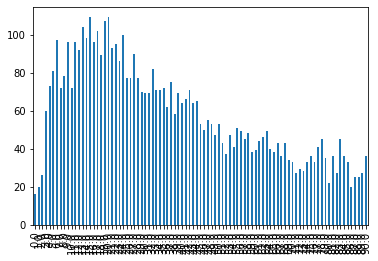

In [53]:
# plot the top 90 values (90 DAYS Readmission days) and its counts as bar plot
adm['DAYS_WITHIN_NEXT_ADMIT'].value_counts().sort_index()[:90].plot.bar()

<AxesSubplot:>

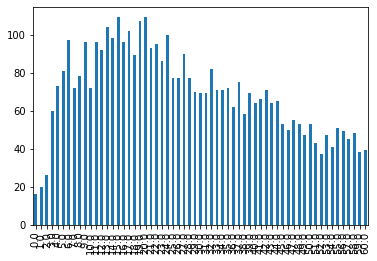

In [54]:
# plot the top 90 values (60 DAYS Readmission days) and its counts as bar plot
adm['DAYS_WITHIN_NEXT_ADMIT'].value_counts().sort_index()[:60].plot.bar()

<AxesSubplot:>

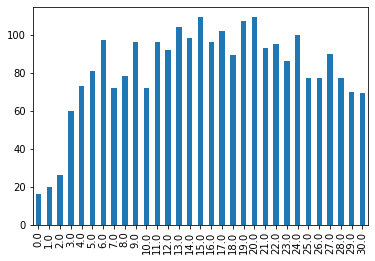

In [55]:
# plot the top 30 values (30 DAYS Readmission days) and its counts as bar plot
adm['DAYS_WITHIN_NEXT_ADMIT'].value_counts().sort_index()[:30].plot.bar()

<AxesSubplot:>

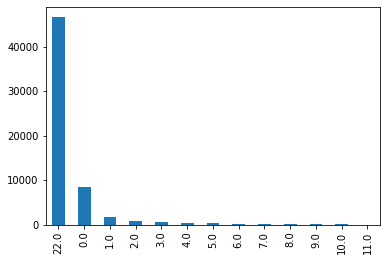

In [56]:
# plot years unit for the next readmission and its counts as bar plot
(adm['DAYS_WITHIN_NEXT_ADMIT'] // 365).value_counts().plot.bar()

<AxesSubplot:>

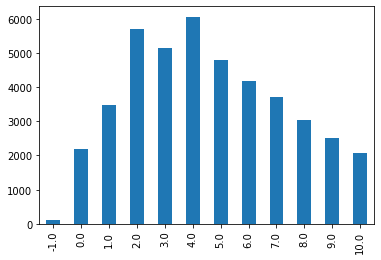

In [57]:
# plot the sorted top 10 days in hospital ant its value counts as bar plot 
adm['DAYS_IN_HOSPITAL'].value_counts().sort_index()[:10].plot.bar()

<AxesSubplot:xlabel='DAYS_IN_HOSPITAL'>

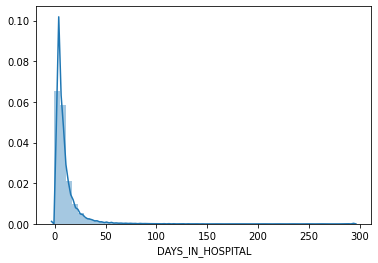

In [58]:
# get the distribution plot of the DAYS IN HOSPITAL values
sns.distplot(adm.DAYS_IN_HOSPITAL)

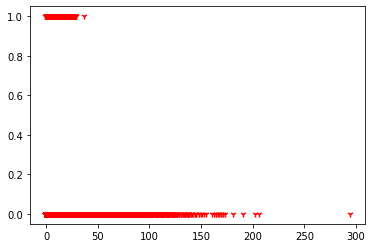

In [59]:
# get the scatter plot of the TARGET values and the DAYS IN HOSPITAL
plt.scatter(adm.DAYS_IN_HOSPITAL, adm.TARGET, c='r', marker='1')

In [60]:
# get the correlation of the TARGET variables
adm.corr()['TARGET']

ROW_ID                    0.003362
SUBJECT_ID                0.006839
HADM_ID                  -0.001086
HOSPITAL_EXPIRE_FLAG     -0.057916
HAS_CHARTEVENTS_DATA     -0.061368
DAYS_IN_HOSPITAL         -0.045178
DAYS_WITHIN_NEXT_ADMIT   -0.435745
TIME_IN_EMERGENCY_WARD    0.042624
DIFF_TIME_DEATH_DISCH    -0.014700
TARGET                    1.000000
Name: TARGET, dtype: float64

<AxesSubplot:xlabel='DAYS_IN_HOSPITAL'>

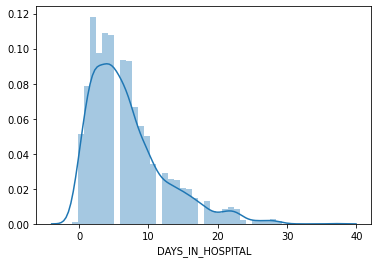

In [61]:
# the distribution plot of the TARGET variable with the DAYS IN HOSPITAL
sns.distplot(adm.loc[adm.TARGET == 1, 'DAYS_IN_HOSPITAL'])

<AxesSubplot:xlabel='DAYS_IN_HOSPITAL'>

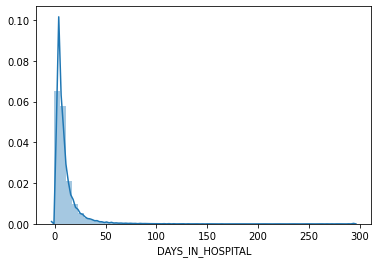

In [62]:
## the distribution plot of the TARGET variable with the DAYS IN HOSPITAL
sns.distplot(adm.loc[adm.TARGET == 0, 'DAYS_IN_HOSPITAL'].fillna(-1))

Now we check the different columns and the corresponding value counts of them and decide for them what NaN values needs to be filled and consequently make hypothesis and test them using correlation analysis, regression analayis, chi-square test

<AxesSubplot:>

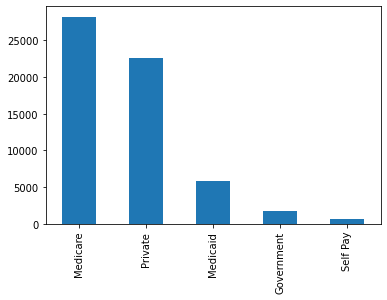

In [63]:
## get insurance plots
adm.INSURANCE.value_counts().plot.bar()

<AxesSubplot:>

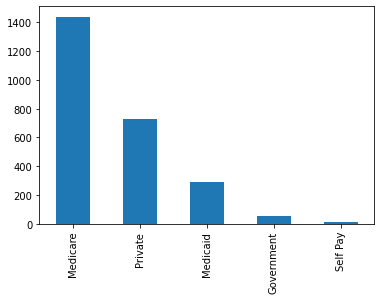

In [64]:
## get insurance plot when TARGET == 1
## there is a high chance that the TARGET == 1 when INSURANCE is MEdicare
adm.loc[adm.TARGET == 1, 'INSURANCE'].value_counts().plot.bar()

<AxesSubplot:>

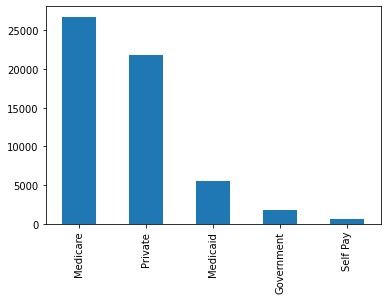

In [65]:
## get insurance plot when TARGET == 0
adm.loc[adm.TARGET == 0, 'INSURANCE'].value_counts().plot.bar()

<AxesSubplot:>

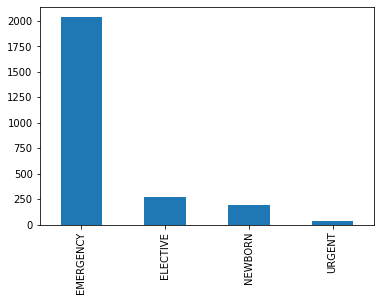

In [66]:
## get the ADMISSION TYPES when TARGET == 1
## most of the ADMISSIONS are EMERGENCY
adm.loc[adm.TARGET == 1].ADMISSION_TYPE.value_counts().plot.bar()

<AxesSubplot:>

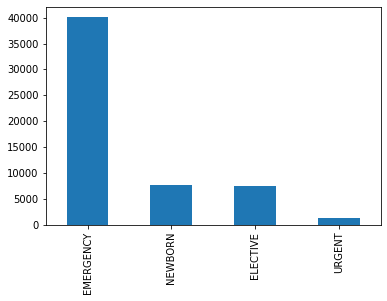

In [67]:
## get the ADMISSION TYPE plot when TARGET == 0
adm.loc[adm.TARGET == 0].ADMISSION_TYPE.value_counts().plot.bar()

In [68]:
adm.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'NEXT_ADMITTIME',
       'DAYS_IN_HOSPITAL', 'DAYS_WITHIN_NEXT_ADMIT', 'TIME_IN_EMERGENCY_WARD',
       'DIFF_TIME_DEATH_DISCH', 'TARGET'],
      dtype='object')

In [69]:
adm.TARGET

211      0
212      0
213      0
214      0
215      0
        ..
56435    0
56436    0
56437    0
56565    0
56566    0
Name: TARGET, Length: 58976, dtype: int64

In [70]:
adm.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'NEXT_ADMITTIME',
       'DAYS_IN_HOSPITAL', 'DAYS_WITHIN_NEXT_ADMIT', 'TIME_IN_EMERGENCY_WARD',
       'DIFF_TIME_DEATH_DISCH', 'TARGET'],
      dtype='object')

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='DAYS_WITHIN_NEXT_ADMIT'>

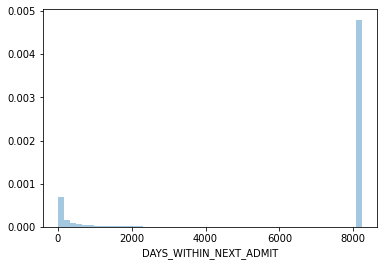

In [71]:
## get the distribution plot for the DAYS_WITHIN_NEXT_ADMIT
sns.distplot(adm.DAYS_WITHIN_NEXT_ADMIT)

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='DAYS_WITHIN_NEXT_ADMIT'>

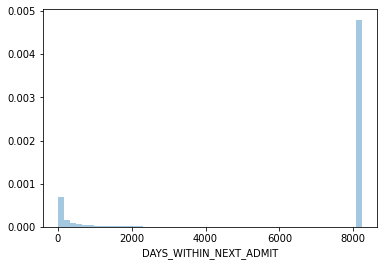

In [72]:
## get the DAYS_WITHIN_NEXT_ADMIT for when DAYS_WITHIN_NEXT_ADMIT is not NaN
sns.distplot(adm.loc[adm.DAYS_WITHIN_NEXT_ADMIT.notna()].DAYS_WITHIN_NEXT_ADMIT)

<AxesSubplot:xlabel='INSURANCE', ylabel='DAYS_WITHIN_NEXT_ADMIT'>

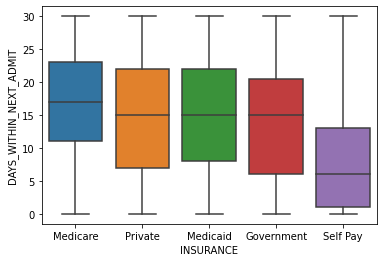

In [73]:
# box plot of the INSURANCE for DAYS WITHIN NEXT ADMIT

sns.boxplot(x='INSURANCE', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])

In [74]:
# get spearman correlation for the INSURANCE One hot encoded values with the TARGET values
pd.get_dummies(adm.INSURANCE).corrwith(adm.TARGET, method='spearman')

Government   -0.010463
Medicaid      0.012702
Medicare      0.038558
Private      -0.041441
Self Pay     -0.010898
dtype: float64

In [75]:
# get the INSRUANCE correlation one hot representation for the DAYS IN HOSPITAL
pd.get_dummies(adm.INSURANCE).corrwith(adm.DAYS_IN_HOSPITAL, method='spearman')

Government   -0.023306
Medicaid     -0.007343
Medicare      0.097673
Private      -0.077255
Self Pay     -0.050004
dtype: float64

In [76]:
# get the INSURANCE correlation with the TIME IN EMERGENCY WARD
pd.get_dummies(adm.INSURANCE).corrwith(adm.TIME_IN_EMERGENCY_WARD, method='spearman')

Government   -0.002078
Medicaid      0.028020
Medicare      0.195138
Private      -0.222653
Self Pay      0.027396
dtype: float64

<AxesSubplot:xlabel='ADMISSION_TYPE', ylabel='DAYS_WITHIN_NEXT_ADMIT'>

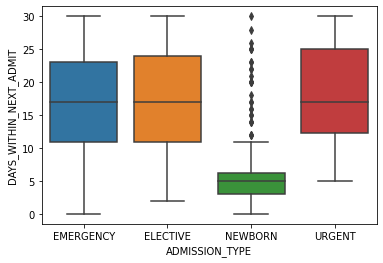

In [77]:
## the boxplot of the ADMISSION TYPE with the DAYS WITHIN NEXT ADMIT
sns.boxplot(x='ADMISSION_TYPE', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])

In [78]:
# the ADMISSION TYPE correlation with the TARGET correlation
pd.get_dummies(adm.ADMISSION_TYPE).corrwith(adm.TARGET, method='spearman')

ELECTIVE    -0.015946
EMERGENCY    0.043021
NEWBORN     -0.035694
URGENT      -0.013080
dtype: float64

<AxesSubplot:>

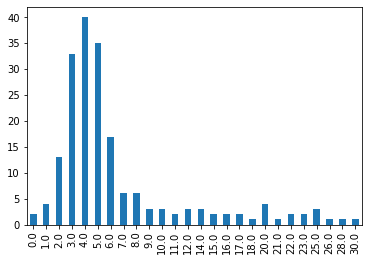

In [79]:
# plot the TARGET == 1 and ADMISSION TYPE == NEWBORN with the DAYS WITHIN NEXT ADMIT bar plot to see the value count distribution
adm.loc[(adm.TARGET == 1) & (adm.ADMISSION_TYPE == 'NEWBORN'), 'DAYS_WITHIN_NEXT_ADMIT'].value_counts().sort_index().plot.bar()

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'CLINIC REFERRAL/PREMATURE'),
  Text(1, 0, 'EMERGENCY ROOM ADMIT'),
  Text(2, 0, 'TRANSFER FROM HOSP/EXTRAM'),
  Text(3, 0, 'PHYS REFERRAL/NORMAL DELI'),
  Text(4, 0, 'TRANSFER FROM OTHER HEALT'),
  Text(5, 0, 'HMO REFERRAL/SICK'),
  Text(6, 0, 'TRANSFER FROM SKILLED NUR'),
  Text(7, 0, '** INFO NOT AVAILABLE **')])

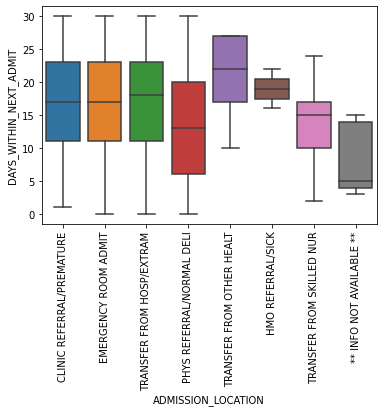

In [80]:
# boxplot for the ADMISSION LOCATION AND THE DAYS WITHIN NEXT ADMIT
sns.boxplot(x='ADMISSION_LOCATION', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

In [82]:
# the DISCHARGE LOCATION and the TARGET correlation
pd.get_dummies(adm.DISCHARGE_LOCATION).corrwith(adm.TARGET, method='spearman')

DEAD/EXPIRED                -0.057916
DISC-TRAN CANCER/CHLDRN H   -0.010013
DISC-TRAN TO FEDERAL HC     -0.002890
DISCH-TRAN TO PSYCH HOSP    -0.011704
HOME                        -0.017296
HOME HEALTH CARE             0.003489
HOME WITH HOME IV PROVIDR    0.000321
HOSPICE-HOME                -0.010405
HOSPICE-MEDICAL FACILITY    -0.010791
ICF                          0.005893
LEFT AGAINST MEDICAL ADVI    0.023872
LONG TERM CARE HOSPITAL      0.047627
OTHER FACILITY               0.000770
REHAB/DISTINCT PART HOSP     0.009277
SHORT TERM HOSPITAL          0.004351
SNF                          0.037230
SNF-MEDICAID ONLY CERTIF    -0.000871
dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'HOME HEALTH CARE'),
  Text(1, 0, 'SNF'),
  Text(2, 0, 'HOME'),
  Text(3, 0, 'DEAD/EXPIRED'),
  Text(4, 0, 'SHORT TERM HOSPITAL'),
  Text(5, 0, 'REHAB/DISTINCT PART HOSP'),
  Text(6, 0, 'LONG TERM CARE HOSPITAL'),
  Text(7, 0, 'DISC-TRAN CANCER/CHLDRN H'),
  Text(8, 0, 'LEFT AGAINST MEDICAL ADVI'),
  Text(9, 0, 'HOME WITH HOME IV PROVIDR'),
  Text(10, 0, 'DISCH-TRAN TO PSYCH HOSP'),
  Text(11, 0, 'HOSPICE-HOME'),
  Text(12, 0, 'OTHER FACILITY'),
  Text(13, 0, 'ICF')])

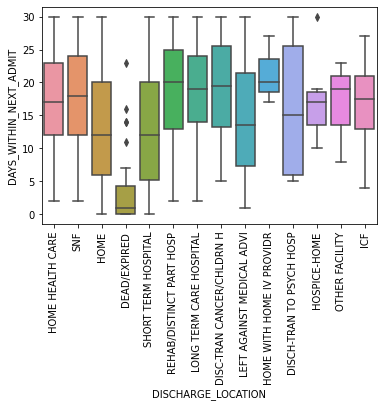

In [83]:
# the DISCHARGE LOCATION box plot with the DAYS WITHIN NEXT ADMIT when for the patient who are admitted again
sns.boxplot(x='DISCHARGE_LOCATION', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, 'ENGL'),
  Text(1, 0, 'PTUN'),
  Text(2, 0, '*CHI'),
  Text(3, 0, 'RUSS'),
  Text(4, 0, 'SPAN'),
  Text(5, 0, 'PORT'),
  Text(6, 0, 'VIET'),
  Text(7, 0, 'HAIT'),
  Text(8, 0, 'GREE'),
  Text(9, 0, 'CAMB'),
  Text(10, 0, 'CANT'),
  Text(11, 0, '*HUN'),
  Text(12, 0, 'ITAL'),
  Text(13, 0, 'POLI'),
  Text(14, 0, 'CAPE'),
  Text(15, 0, 'ARAB'),
  Text(16, 0, 'MAND'),
  Text(17, 0, 'SOMA'),
  Text(18, 0, 'PERS'),
  Text(19, 0, 'ETHI'),
  Text(20, 0, 'KORE'),
  Text(21, 0, '*YID'),
  Text(22, 0, 'HIND'),
  Text(23, 0, 'AMER'),
  Text(24, 0, '*ARM'),
  Text(25, 0, '*MOR'),
  Text(26, 0, 'ALBA')])

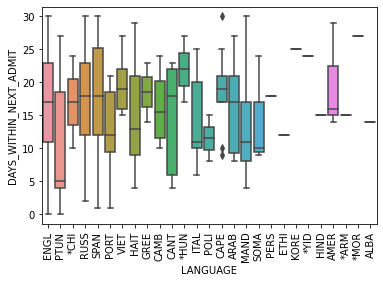

In [84]:
# boxplot for the LANGUAGE and the DAYS WITHIN NEXT ADMIT for the patient who are admitted again
sns.boxplot(x='LANGUAGE', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

In [85]:
# fill the language column with the maximum value occuring in the dataset
adm.loc[adm.LANGUAGE.isna(), 'LANGUAGE'] = adm.LANGUAGE.value_counts().nlargest(1).index[0]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, 'ENGL'),
  Text(1, 0, 'PTUN'),
  Text(2, 0, '*CHI'),
  Text(3, 0, 'RUSS'),
  Text(4, 0, 'SPAN'),
  Text(5, 0, 'PORT'),
  Text(6, 0, 'VIET'),
  Text(7, 0, 'HAIT'),
  Text(8, 0, 'GREE'),
  Text(9, 0, 'CAMB'),
  Text(10, 0, 'CANT'),
  Text(11, 0, '*HUN'),
  Text(12, 0, 'ITAL'),
  Text(13, 0, 'POLI'),
  Text(14, 0, 'CAPE'),
  Text(15, 0, 'ARAB'),
  Text(16, 0, 'MAND'),
  Text(17, 0, 'SOMA'),
  Text(18, 0, 'PERS'),
  Text(19, 0, 'ETHI'),
  Text(20, 0, 'KORE'),
  Text(21, 0, '*YID'),
  Text(22, 0, 'HIND'),
  Text(23, 0, 'AMER'),
  Text(24, 0, '*ARM'),
  Text(25, 0, '*MOR'),
  Text(26, 0, 'ALBA')])

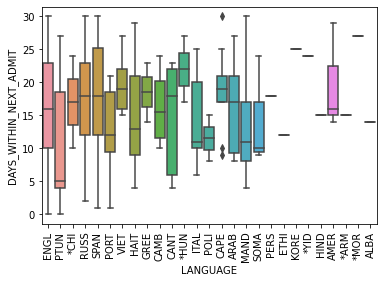

In [86]:
# the BOXPLOT for the LANGUAGE and the DAYS WITHIN NEXT ADMIT for the patient who are admitted again
sns.boxplot(x='LANGUAGE', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'NOT SPECIFIED'),
  Text(1, 0, 'PROTESTANT QUAKER'),
  Text(2, 0, 'CATHOLIC'),
  Text(3, 0, 'JEWISH'),
  Text(4, 0, 'UNOBTAINABLE'),
  Text(5, 0, 'OTHER'),
  Text(6, 0, 'EPISCOPALIAN'),
  Text(7, 0, 'CHRISTIAN SCIENTIST'),
  Text(8, 0, 'GREEK ORTHODOX'),
  Text(9, 0, 'BUDDHIST'),
  Text(10, 0, 'MUSLIM'),
  Text(11, 0, "JEHOVAH'S WITNESS"),
  Text(12, 0, 'UNITARIAN-UNIVERSALIST'),
  Text(13, 0, 'HINDU'),
  Text(14, 0, 'ROMANIAN EAST. ORTH'),
  Text(15, 0, 'HEBREW'),
  Text(16, 0, '7TH DAY ADVENTIST')])

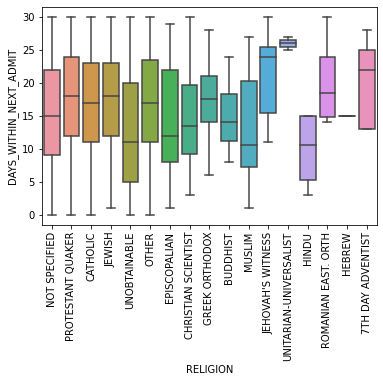

In [87]:
# the boxplot for the RELIGION and the DAYS WITHIN NEXT ADMIT for the patient who are admiited again
sns.boxplot(x='RELIGION', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

In [88]:
adm.RELIGION.value_counts()

CATHOLIC                  20606
NOT SPECIFIED             11753
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: RELIGION, dtype: int64

In [89]:
# fill RELIGION column value with 'NOT SPECIFIED'
adm.loc[adm.RELIGION.isna(), 'RELIGION'] = 'NOT SPECIFIED'

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'NOT SPECIFIED'),
  Text(1, 0, 'PROTESTANT QUAKER'),
  Text(2, 0, 'CATHOLIC'),
  Text(3, 0, 'JEWISH'),
  Text(4, 0, 'UNOBTAINABLE'),
  Text(5, 0, 'OTHER'),
  Text(6, 0, 'EPISCOPALIAN'),
  Text(7, 0, 'CHRISTIAN SCIENTIST'),
  Text(8, 0, 'GREEK ORTHODOX'),
  Text(9, 0, 'BUDDHIST'),
  Text(10, 0, 'MUSLIM'),
  Text(11, 0, "JEHOVAH'S WITNESS"),
  Text(12, 0, 'UNITARIAN-UNIVERSALIST'),
  Text(13, 0, 'HINDU'),
  Text(14, 0, 'ROMANIAN EAST. ORTH'),
  Text(15, 0, 'HEBREW'),
  Text(16, 0, '7TH DAY ADVENTIST')])

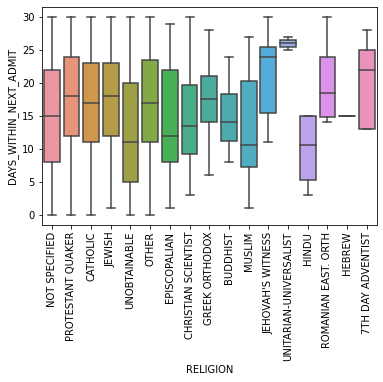

In [90]:
# plot the box plot again after filling NaN values
sns.boxplot(x='RELIGION', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'MARRIED'),
  Text(1, 0, 'SINGLE'),
  Text(2, 0, 'WIDOWED'),
  Text(3, 0, 'DIVORCED'),
  Text(4, 0, 'SEPARATED'),
  Text(5, 0, 'UNKNOWN (DEFAULT)')])

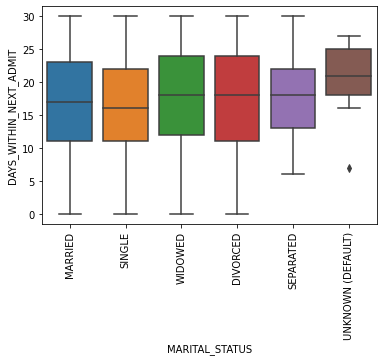

In [91]:
# boxplot of the MARITAL STATUS and the DAYS WITHIN NEXT ADMIT for the patient who are admitted again
sns.boxplot(x='MARITAL_STATUS', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

In [92]:
# check the NaN values
adm.MARITAL_STATUS.isna().value_counts()

False    48848
True     10128
Name: MARITAL_STATUS, dtype: int64

In [93]:
# fill the NaN values with the 'UNKNOWN (DEFAULT)' values as analysed above
adm.loc[adm.MARITAL_STATUS.isna(), 'MARITAL_STATUS'] = 'UNKNOWN (DEFAULT)'

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'MARRIED'),
  Text(1, 0, 'SINGLE'),
  Text(2, 0, 'WIDOWED'),
  Text(3, 0, 'UNKNOWN (DEFAULT)'),
  Text(4, 0, 'DIVORCED'),
  Text(5, 0, 'SEPARATED')])

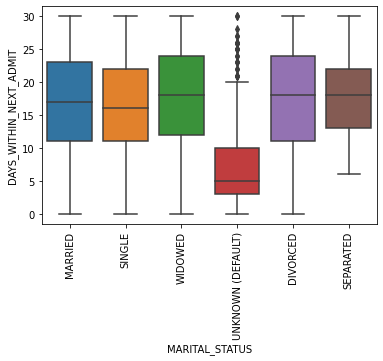

In [94]:
# plot it again after filling NaN values
sns.boxplot(x='MARITAL_STATUS', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 [Text(0, 0, 'WHITE'),
  Text(1, 0, 'BLACK/AFRICAN AMERICAN'),
  Text(2, 0, 'UNKNOWN/NOT SPECIFIED'),
  Text(3, 0, 'ASIAN'),
  Text(4, 0, 'OTHER'),
  Text(5, 0, 'BLACK/AFRICAN'),
  Text(6, 0, 'HISPANIC OR LATINO'),
  Text(7, 0, 'PATIENT DECLINED TO ANSWER'),
  Text(8, 0, 'HISPANIC/LATINO - PUERTO RICAN'),
  Text(9, 0, 'AMERICAN INDIAN/ALASKA NATIVE'),
  Text(10, 0, 'WHITE - RUSSIAN'),
  Text(11, 0, 'ASIAN - CHINESE'),
  Text(12, 0, 'MIDDLE EASTERN'),
  Text(13, 0, 'MULTI RACE ETHNICITY'),
  Text(14, 0, 'BLACK/HAITIAN'),
  Text(15, 0, 'HISPANIC/LATINO - DOMINICAN'),
  Text(16, 0, 'ASIAN - VIETNAMESE'),
  Text(17, 0, 'WHITE - OTHER EUROPEAN'),
  Text(18, 0, 'ASIAN - ASIAN INDIAN'),
  Text(19, 0, 'UNABLE TO OBTAIN'),
  Text(20, 0, 'PORTUGUESE'),
  Text(21, 0, 'BLACK/CAPE VERDEAN'),
  Text(22, 0, 'ASIAN - FILIPINO'),
  Text(23, 0, 'HISPANIC/LATINO - CENTRAL AMERICAN (OT

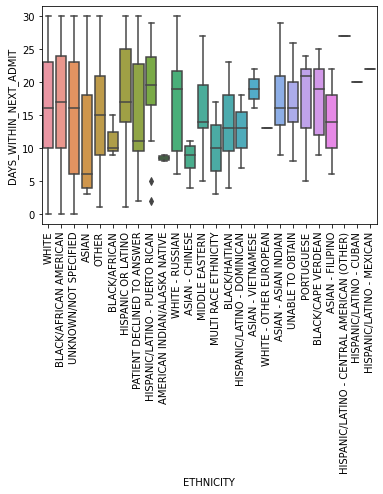

In [95]:
# bxoplot for the ETHINICY and DAYS WITHIN NEXT ADMIT for patient readmitted again
sns.boxplot(x='ETHNICITY', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

<AxesSubplot:>

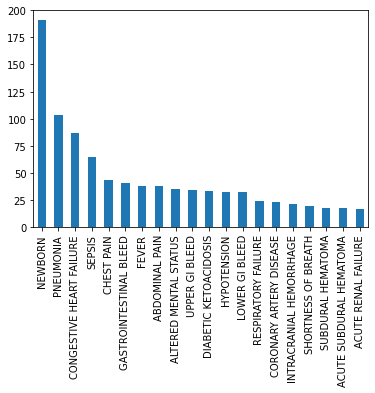

In [96]:
# do analysis on DIAGNOSIS value counts
adm.loc[adm.TARGET == 1]['DIAGNOSIS'].value_counts().nlargest(20).plot.bar()

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='DIAGNOSIS'>

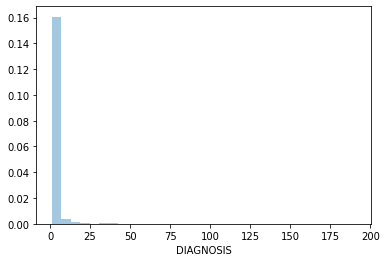

In [97]:
# plot distribution graph for the DIAGNOSIS value counts
sns.distplot(adm.loc[adm.TARGET == 1]['DIAGNOSIS'].value_counts())

Clean the DIAGNOSIS column for further use as a feature

In [98]:
import re, string

In [99]:
# remove the extra punctuations / sysmbols
diagnosis_re = re.compile(r"[\"#$%&\'\(\)\*+,.:<=>?@\[\\\]^_`\{|\}~]")

In [100]:
# remove the extra -;/ etc which occurs in DIAGNOSIS column
diagnosis_re1 = re.compile(r"[-;/]")

In [101]:
# check the DIAGNOSIS NaN values
adm.DIAGNOSIS.isna().value_counts()

False    58951
True        25
Name: DIAGNOSIS, dtype: int64

In [102]:
# fill the DIAGNOSIS vlaues with UNKNOWN default value
adm.loc[adm.DIAGNOSIS.isna(), 'DIAGNOSIS'] = 'UNKNOWN'

In [103]:
# remove extra spaces and extra punctuation characters
adm.DIAGNOSIS = adm.DIAGNOSIS.apply(lambda x: diagnosis_re1.sub(' ', x)).apply(lambda x: diagnosis_re.sub('', x))

<AxesSubplot:>

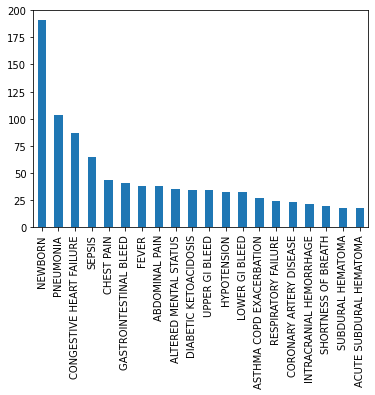

In [104]:
# plot the largest occuring DIAGNOSIS vlaues
adm.loc[adm.TARGET == 1]['DIAGNOSIS'].value_counts().nlargest(20).plot.bar()

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='DIAGNOSIS'>

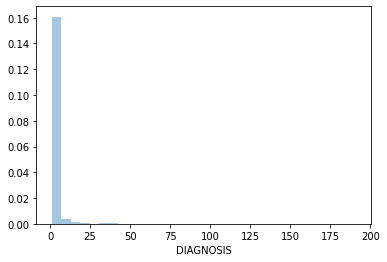

In [105]:
# plot the distribution graph of the DIAGNOSIS values
sns.distplot(adm.loc[adm.TARGET == 1]['DIAGNOSIS'].value_counts())

Do feature engineering on the DIAGNOSIS values

In [106]:
# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [107]:
tfidf = TfidfVectorizer()

In [108]:
# train the TfidfVectorizer object
diagnosis_features = tfidf.fit_transform(adm.DIAGNOSIS.fillna('UNKNOWN').values).toarray()

In [109]:
# get it into a dataframe for further analysis with TARGET columns
tfidf_df = pd.DataFrame(diagnosis_features, columns=tfidf.get_feature_names())

In [110]:
del tfidf, diagnosis_features

In [111]:
# copy the TARGET column
tfidf_df.loc[:, 'TARGET'] = adm.TARGET

In [112]:
import gc
gc.collect()

75

In [113]:
# get the correlation of each diagnosis feature with the Target column
corr = []

for col in tfidf_df.columns:
  corr.append(tfidf_df[col].corr(tfidf_df['TARGET'], method='spearman'))

In [114]:
# plot the most correlation wise diagnosis feature with the TARGET column
pd.Series(corr, index=tfidf_df.columns).sort_values(ascending=False)

TARGET                   1.000000
ft                       0.019462
obstructivepulmonary     0.019462
cellulitiscolonoscopy    0.019462
aniogram                 0.019462
                           ...   
embolis                 -0.007362
fibrillation            -0.007768
gangrene                -0.007991
stemi                   -0.008557
airway                  -0.009025
Length: 6294, dtype: float64

In [115]:
# plot the least correlated features wise DIAGNOSIS feature with the TARGET columns
pd.Series(corr, index=tfidf_df.columns).sort_values()

airway                  -0.009025
stemi                   -0.008557
gangrene                -0.007991
fibrillation            -0.007768
embolis                 -0.007362
                           ...   
aniogram                 0.019462
cellulitiscolonoscopy    0.019462
obstructivepulmonary     0.019462
ft                       0.019462
TARGET                   1.000000
Length: 6294, dtype: float64

In [116]:
# get the bool value whether there is any failure word in the diagnosis column
adm.loc[:, 'in_failure'] = adm.DIAGNOSIS.apply(lambda x: int('failure' in x.lower()))

In [117]:
# corelation of in_failure with the targte col
adm.in_failure.corr(adm.TARGET)

0.03032207780279582

In [118]:
# correlation fo in_failure feature with HOSPITAL_EXPIRE_FLAG
adm.in_failure.corr(adm.HOSPITAL_EXPIRE_FLAG)

0.062478071812382394

In [119]:
# correlation of HOSPITAL_EXPIRE_FLAG with the TARGET columns
adm['HOSPITAL_EXPIRE_FLAG'].astype(int).corr(adm.TARGET)

-0.057915975095876454

In [120]:
del tfidf_df

In [121]:
gc.collect()

100

In [122]:
# check the correlation of the columns by doing LabelEncoding them
from sklearn.preprocessing import LabelEncoder

In [123]:
le = LabelEncoder()

In [124]:
new_adm = adm.copy()

In [125]:
# verifyu the NaN values in the columns
for col in new_adm.columns:
  print(col)
  print(new_adm[col].isna().value_counts().index)
  print('----------------------------------------------')

ROW_ID
Index([False], dtype='object')
----------------------------------------------
SUBJECT_ID
Index([False], dtype='object')
----------------------------------------------
HADM_ID
Index([False], dtype='object')
----------------------------------------------
ADMITTIME
Index([False], dtype='object')
----------------------------------------------
DISCHTIME
Index([False], dtype='object')
----------------------------------------------
DEATHTIME
Index([True, False], dtype='object')
----------------------------------------------
ADMISSION_TYPE
Index([False], dtype='object')
----------------------------------------------
ADMISSION_LOCATION
Index([False], dtype='object')
----------------------------------------------
DISCHARGE_LOCATION
Index([False], dtype='object')
----------------------------------------------
INSURANCE
Index([False], dtype='object')
----------------------------------------------
LANGUAGE
Index([False], dtype='object')
----------------------------------------------
RELIGION

In [126]:
cols = [
        'ADMISSION_TYPE',
        'ADMISSION_LOCATION',
        'DISCHARGE_LOCATION',
        'INSURANCE',
        'LANGUAGE',
        'RELIGION',
        'ETHNICITY',
        'DIAGNOSIS'
]

In [127]:
# LabelEncode only the above columns
for col in cols:
  new_adm[col + '_le'] = le.fit_transform(new_adm[col])

In [128]:
new_adm.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'NEXT_ADMITTIME',
       'DAYS_IN_HOSPITAL', 'DAYS_WITHIN_NEXT_ADMIT', 'TIME_IN_EMERGENCY_WARD',
       'DIFF_TIME_DEATH_DISCH', 'TARGET', 'in_failure', 'ADMISSION_TYPE_le',
       'ADMISSION_LOCATION_le', 'DISCHARGE_LOCATION_le', 'INSURANCE_le',
       'LANGUAGE_le', 'RELIGION_le', 'ETHNICITY_le', 'DIAGNOSIS_le'],
      dtype='object')

In [129]:
# check the correlation of the above label encoded column with the TARGET columns
new_adm.corr(method="spearman")['TARGET'].filter(like='le')

ADMISSION_TYPE_le       -0.016746
ADMISSION_LOCATION_le   -0.028276
DISCHARGE_LOCATION_le    0.068068
INSURANCE_le            -0.037283
LANGUAGE_le              0.003980
RELIGION_le             -0.014266
ETHNICITY_le            -0.009986
DIAGNOSIS_le            -0.014893
Name: TARGET, dtype: float64

<AxesSubplot:>

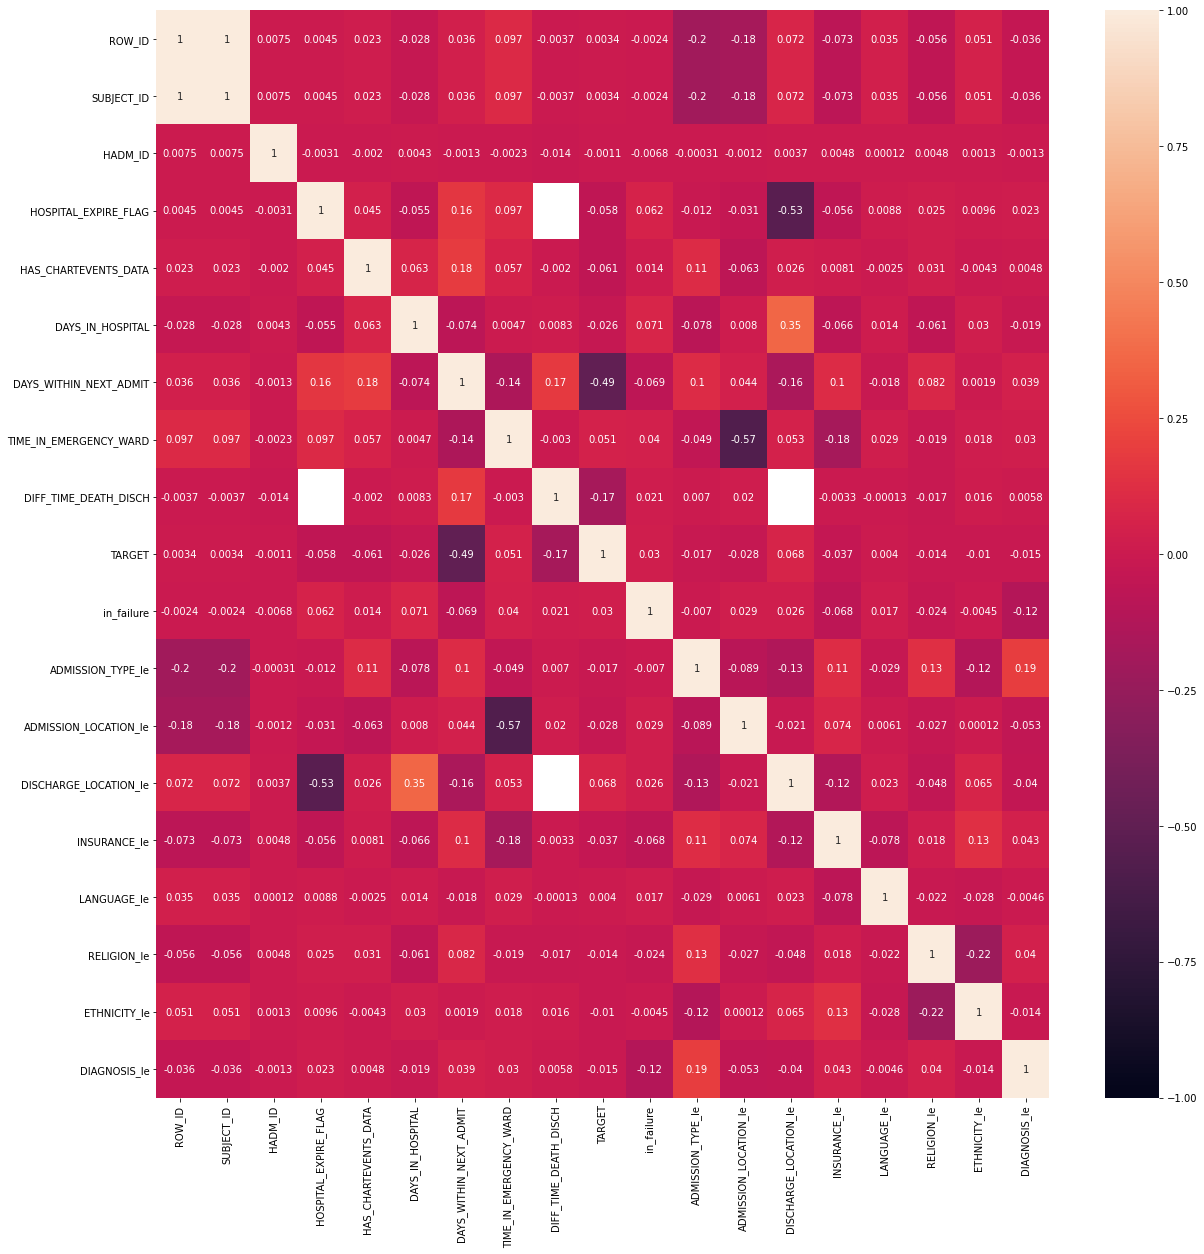

In [130]:
# plot the heatmap to get a sense of correlation distribution
plt.figure(figsize=(20, 20))
sns.heatmap(new_adm.corr(method="spearman"), vmin=-1, vmax=1, annot=True)

In [131]:
cols = [
        'ADMISSION_TYPE',
        'ADMISSION_LOCATION',
        'DISCHARGE_LOCATION',
        'INSURANCE',
        'LANGUAGE',
        'RELIGION',
        'ETHNICITY',
        # 'DIAGNOSIS'
]

In [132]:
# check the correlation by doing One hot encoding the above cols only
from sklearn.preprocessing import OneHotEncoder

In [133]:
ohe = OneHotEncoder()

In [134]:
new_adm1 = adm.copy()

In [135]:
# verify for NaN values and change the representation to the One Hot encoding
for index, col in enumerate(cols):
  # print(col, new_adm1[col].isna().value_counts().index)
  sp_mat = ohe.fit_transform(new_adm1[col].values.reshape((-1, 1)))
  new_adm1 = pd.concat([new_adm1, pd.DataFrame(sp_mat.toarray(), columns=[col + 'ohe_{}'.format(i) for i in range(sp_mat[0].shape[1])])], axis=1)
  # print(new_adm[col].isna().value_counts().index)
  # print(new_adm[cols[index + 1:index + 2]].value_counts().index)
  # print('-----------------------')

In [136]:
new_adm1.DAYS_WITHIN_NEXT_ADMIT.isna().value_counts()

False    58976
Name: DAYS_WITHIN_NEXT_ADMIT, dtype: int64

In [137]:
new_adm1.TARGET.isna().value_counts()

False    58976
Name: TARGET, dtype: int64

In [138]:
# import for chisquare tests
from scipy.stats import chisquare

In [139]:
# do chisquare test for the DAYS_WITHIN_NEXT_ADMIT and TARGET values
chisquare(new_adm1[['DAYS_WITHIN_NEXT_ADMIT', 'TARGET']].astype(float))

Power_divergenceResult(statistic=array([9.13548875e+07, 5.64490000e+04]), pvalue=array([0., 1.]))

In [140]:
# do the chisquare test for the numeric columns with the TARGET columns
for each_col in new_adm1.columns:
  if pd.api.types.is_numeric_dtype(new_adm1[each_col]):
    print(each_col, chisquare(new_adm1[[each_col, 'TARGET']]))

ROW_ID Power_divergenceResult(statistic=array([5.79684933e+08, 5.64490000e+04]), pvalue=array([0., 1.]))
SUBJECT_ID Power_divergenceResult(statistic=array([1.37882804e+09, 5.64490000e+04]), pvalue=array([0., 1.]))
HADM_ID Power_divergenceResult(statistic=array([3.28056523e+08, 5.64490000e+04]), pvalue=array([0., 1.]))
HOSPITAL_EXPIRE_FLAG Power_divergenceResult(statistic=array([53122., 56449.]), pvalue=array([1., 1.]))
HAS_CHARTEVENTS_DATA Power_divergenceResult(statistic=array([ 1592., 56449.]), pvalue=array([1., 1.]))
DAYS_IN_HOSPITAL Power_divergenceResult(statistic=array([951547.56210755,  56449.        ]), pvalue=array([0., 1.]))
DAYS_WITHIN_NEXT_ADMIT Power_divergenceResult(statistic=array([9.13548875e+07, 5.64490000e+04]), pvalue=array([0., 1.]))
TIME_IN_EMERGENCY_WARD Power_divergenceResult(statistic=array([13480.02120254, 56449.        ]), pvalue=array([1., 1.]))
DIFF_TIME_DEATH_DISCH Power_divergenceResult(statistic=array([   nan, 56449.]), pvalue=array([nan,  1.]))
TARGET Po

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


LANGUAGEohe_27 Power_divergenceResult(statistic=array([58973., 56449.]), pvalue=array([0.50154884, 1.        ]))
LANGUAGEohe_28 Power_divergenceResult(statistic=array([58974., 56449.]), pvalue=array([0.50038721, 1.        ]))
LANGUAGEohe_29 Power_divergenceResult(statistic=array([58975., 56449.]), pvalue=array([0.49922559, 1.        ]))
LANGUAGEohe_30 Power_divergenceResult(statistic=array([58975., 56449.]), pvalue=array([0.49922559, 1.        ]))
LANGUAGEohe_31 Power_divergenceResult(statistic=array([58975., 56449.]), pvalue=array([0.49922559, 1.        ]))
LANGUAGEohe_32 Power_divergenceResult(statistic=array([58975., 56449.]), pvalue=array([0.49922559, 1.        ]))
LANGUAGEohe_33 Power_divergenceResult(statistic=array([58975., 56449.]), pvalue=array([0.49922559, 1.        ]))
LANGUAGEohe_34 Power_divergenceResult(statistic=array([58975., 56449.]), pvalue=array([0.49922559, 1.        ]))
LANGUAGEohe_35 Power_divergenceResult(statistic=array([58975., 56449.]), pvalue=array([0.4992255